In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

## Loading AGNEWS Dataset

In [2]:
import pandas as pd

train_data_path = "C:/Users/Deepjyoti Bodo/agnews/train.csv"
train_df = pd.read_csv(train_data_path)

print("Training Data:")
print(train_df.head())


test_data_path = "C:/Users/Deepjyoti Bodo/agnews/test.csv"
test_df = pd.read_csv(test_data_path)


print("\nTesting Data:")
print(test_df.head())

Training Data:
   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  

Testing Data:
   Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2            4    

In [3]:
zero_numbering = {1:0, 2:1, 3:2, 4:3}
train_df['Class Index'] = train_df['Class Index'].apply(lambda x: zero_numbering[x])
test_df['Class Index'] = test_df['Class Index'].apply(lambda x: zero_numbering[x])

In [4]:
test_df

,Class Index,Title,Description
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,0,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,1,Void is filled with Clement,With the supply of attractive pitching options...
7597,1,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,2,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [5]:
train_df

,Class Index,Title,Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,0,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,1,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,1,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,1,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [6]:
import torch
import torch.nn as nn
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error


In [7]:
tok = spacy.load('en_core_web_sm')

def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]
    

In [8]:
counts = Counter()
for index, row in train_df.iterrows():
    counts.update(tokenize(row['Title']))

In [9]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 32181
num_words after: 20937


In [14]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)
    

In [15]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length


In [16]:
max_length=100
def encode_and_pad(sentence, vocab2index):
    encoded = encode_sentence(sentence, vocab2index)  
    padded_encoded = np.pad(encoded, (0, max_length - len(encoded)), 'constant', constant_values=0)
    return padded_encoded[:max_length]  

In [17]:
train_df['encoded'], train_df['length'] = zip(*train_df['Title'].apply(lambda x: encode_sentence(x, vocab2index)))

In [18]:
max_length = train_df['length'].max()
print("Maximum length in the 'length' column:", max_length)

Maximum length in the 'length' column: 28


In [22]:
train_df.drop(columns=['Description'], inplace=True)

KeyError: "['Description'] not found in axis"

In [20]:
train_df.head()

,Class Index,Title,encoded,length
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"[2, 3, 4, 5, 6, 7, 8, 9, 10, 4, 11, 0, 0, 0, 0...",11
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,"[12, 13, 14, 15, 16, 4, 11, 0, 0, 0, 0, 0, 0, ...",7
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),"[17, 18, 19, 20, 21, 4, 22, 4, 11, 0, 0, 0, 0,...",9
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,"[23, 24, 17, 25, 26, 27, 28, 29, 4, 11, 0, 0, ...",10
4,2,"Oil prices soar to all-time record, posing new...","[17, 30, 31, 32, 33, 34, 35, 4, 36, 37, 38, 32...",16


In [21]:
test_df['encoded'], test_df['length'] = zip(*test_df['Title'].apply(lambda x: encode_sentence(x, vocab2index)))
test_df.head()

,Class Index,Title,Description,encoded,length
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...,"[1121, 67, 434, 1909, 2920, 1513, 1629, 0, 0, ...",7
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...","[9, 578, 452, 87, 4, 403, 629, 628, 1395, 695,...",17
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,"[2296, 4, 197, 1237, 202, 32, 444, 1, 4, 53, 0...",10
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,"[11828, 2324, 1938, 854, 1, 4, 53, 0, 0, 0, 0,...",7
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,"[1846, 4, 3540, 32, 5224, 3213, 9837, 5421, 4,...",10


In [18]:
max_length = train_df['Class Index'].max()
print("Maximum length in the 'length' column:", max_length)

Maximum length in the 'length' column: 3


In [19]:
max_length = train_df['length'].max()
print("Maximum length in the 'length' column:", max_length)

Maximum length in the 'length' column: 28


In [20]:
test_df.drop(columns=['Description'], inplace=True)

In [21]:
test_df.head()

,Class Index,Title,encoded,length
0,2,Fears for T N pension after talks,"[1121, 67, 434, 1909, 2920, 1513, 1629, 0, 0, ...",7
1,3,The Race is On: Second Private Team Sets Launc...,"[9, 578, 452, 87, 4, 403, 629, 628, 1395, 695,...",17
2,3,Ky. Company Wins Grant to Study Peptides (AP),"[2296, 4, 197, 1237, 202, 32, 444, 1, 4, 53, 0...",10
3,3,Prediction Unit Helps Forecast Wildfires (AP),"[11828, 2324, 1938, 854, 1, 4, 53, 0, 0, 0, 0,...",7
4,3,Calif. Aims to Limit Farm-Related Smog (AP),"[1846, 4, 3540, 32, 5224, 3213, 9837, 5421, 4,...",10


In [22]:
unique_values = train_df['Class Index'].unique()

print("Unique values in 'Class Index' column:")
print(unique_values)

Unique values in 'Class Index' column:
[2 3 1 0]


# Spliting Train and Val

In [23]:
X = list(train_df['encoded'])
y = list(train_df['Class Index'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)


## Hyperparameters

In [32]:
EMBEDDING_DIM = 100  
HIDDEN_DIM = 256    
NUM_CLASSES = 4      
BATCH_SIZE = 40   
NUM_EPOCHS = 10    
LEARNING_RATE = 0.001 


In [33]:

X_train = np.array(X_train)
X_valid = np.array(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
valid_dataset = CustomDataset(X_valid_tensor, y_valid_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


## RNN model

In [34]:
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = output[:, -1]  
        return self.fc(output)

# Initialize the model
model = SimpleRNN(input_dim=len(words), hidden_dim=HIDDEN_DIM, output_dim=NUM_CLASSES)




SimpleRNN(
  (embedding): Embedding(20939, 256)
  (rnn): RNN(256, 256)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)


## Training the model

In [35]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer):
    model.to(device) 
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss, valid_accuracy = evaluate_model(model, valid_loader, criterion)
        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%')

def evaluate_model(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = correct / total * 100
    return valid_loss, valid_accuracy

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_model(model, train_loader, valid_loader, num_epochs=NUM_EPOCHS, criterion=criterion, optimizer=optimizer)


Epoch: 1/10, Train Loss: 1.3984, Valid Loss: 1.3888, Valid Accuracy: 24.98%
Epoch: 2/10, Train Loss: 1.4006, Valid Loss: 1.3882, Valid Accuracy: 25.40%
Epoch: 3/10, Train Loss: 1.4017, Valid Loss: 1.3959, Valid Accuracy: 25.45%
Epoch: 4/10, Train Loss: 1.4004, Valid Loss: 1.4027, Valid Accuracy: 24.90%
Epoch: 5/10, Train Loss: 1.4021, Valid Loss: 1.3976, Valid Accuracy: 24.86%
Epoch: 6/10, Train Loss: 1.4014, Valid Loss: 1.3907, Valid Accuracy: 24.79%
Epoch: 7/10, Train Loss: 1.4011, Valid Loss: 1.3968, Valid Accuracy: 24.89%
Epoch: 8/10, Train Loss: 1.4019, Valid Loss: 1.4016, Valid Accuracy: 25.45%
Epoch: 9/10, Train Loss: 1.4011, Valid Loss: 1.4029, Valid Accuracy: 24.86%
Epoch: 10/10, Train Loss: 1.4025, Valid Loss: 1.3962, Valid Accuracy: 24.90%


## Dev Set Scores

Epoch: 1/10, Train Loss: 1.4020, Valid Loss: 1.4025, Valid Accuracy: 24.92%
Epoch: 2/10, Train Loss: 1.4012, Valid Loss: 1.3897, Valid Accuracy: 25.45%
Epoch: 3/10, Train Loss: 1.4006, Valid Loss: 1.3904, Valid Accuracy: 24.90%
Epoch: 4/10, Train Loss: 1.4001, Valid Loss: 1.4040, Valid Accuracy: 25.45%
Epoch: 5/10, Train Loss: 1.4013, Valid Loss: 1.4021, Valid Accuracy: 24.86%
Epoch: 6/10, Train Loss: 1.4016, Valid Loss: 1.3918, Valid Accuracy: 25.11%
Epoch: 7/10, Train Loss: 1.4013, Valid Loss: 1.3952, Valid Accuracy: 25.45%
Epoch: 8/10, Train Loss: 1.4026, Valid Loss: 1.3928, Valid Accuracy: 24.79%
Epoch: 9/10, Train Loss: 1.4017, Valid Loss: 1.3999, Valid Accuracy: 24.79%
Epoch: 10/10, Train Loss: 1.4018, Valid Loss: 1.4148, Valid Accuracy: 24.90%


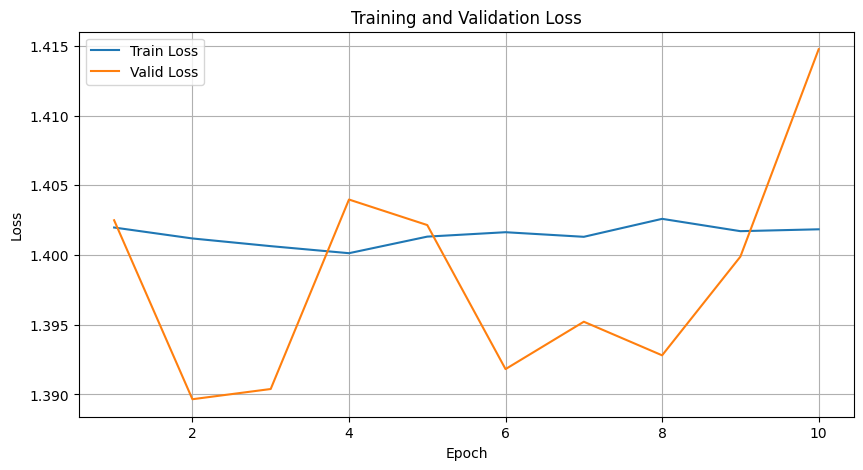

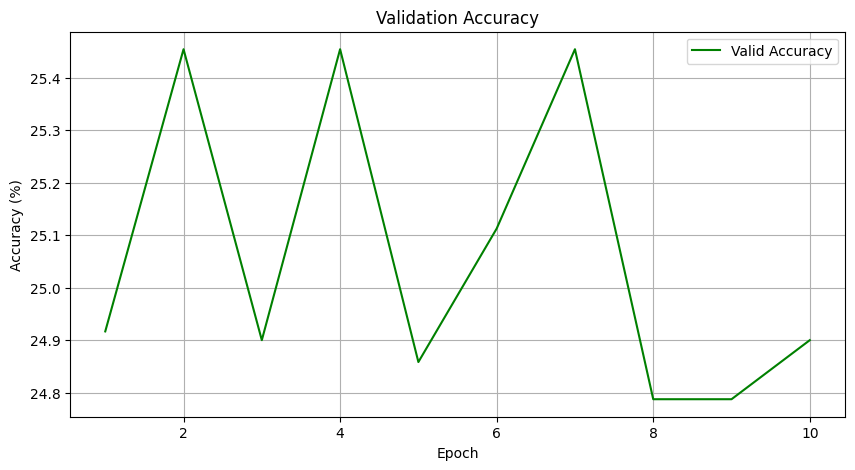

In [38]:
import numpy as np

train_losses = []
valid_losses = []
valid_accuracies = []

def train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer):
    model.to(device) 
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss, valid_accuracy = evaluate_model(model, valid_loader, criterion)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%')

def evaluate_model(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = correct / total * 100
    return valid_loss, valid_accuracy

def plot_metrics(train_losses, valid_losses, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()S 
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, valid_accuracies, label='Valid Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

train_model(model, train_loader, valid_loader, num_epochs=NUM_EPOCHS, criterion=criterion, optimizer=optimizer)

plot_metrics(train_losses, valid_losses, valid_accuracies)

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_evaluation_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nAccuracy Score:", accuracy_score(y_true, y_pred))

In [84]:
test_df['encoded'].head()

0    [1121, 67, 434, 1909, 2920, 1513, 1629, 0, 0, ...
1    [9, 578, 452, 87, 4, 403, 629, 628, 1395, 695,...
2    [2296, 4, 197, 1237, 202, 32, 444, 1, 4, 53, 0...
3    [11828, 2324, 1938, 854, 1, 4, 53, 0, 0, 0, 0,...
4    [1846, 4, 3540, 32, 5224, 3213, 9837, 5421, 4,...
Name: encoded, dtype: object

In [23]:
def make_predictions(model, input_data, device):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(input_data).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_classes = predicted.cpu().numpy()
    return predicted_classes


input_data = test_df['encoded'].iloc[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_data = torch.tensor(input_data).unsqueeze(0) 

input_data = input_data.to(device)

predicted_classes = make_predictions(model, input_data, device)
print("Predicted classes:", predicted_classes)


NameError: name 'model' is not defined

## LSTM

In [40]:

EMBEDDING_DIM = 100
HIDDEN_DIM = 256
NUM_CLASSES = 4
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

X_train = np.array(X_train)
X_valid = np.array(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)


X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

batch_size = 32
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)


In [44]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        return out
    #example data
vocab_size =12000
embed_size = 100
hidden_size = 256 
model = LSTMModel(vocab_size, embed_size, hidden_size)
print(model)


LSTMModel(
  (embedding): Embedding(12000, 12000)
  (lstm): LSTM(12000, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=256, bias=True)
)


In [42]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(NUM_EPOCHS):
    model.to(device)  
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {(correct/total)*100:.2f}%")
    model.eval()
    with torch.no_grad():
        total_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Validation Loss: {total_loss/len(valid_loader):.4f}, Validation Accuracy: {(correct/total)*100:.2f}%")


Epoch [1/10], Loss: 1.4029, Accuracy: 25.07%
Validation Loss: 1.3970, Validation Accuracy: 25.03%
Epoch [2/10], Loss: 1.4035, Accuracy: 25.07%
Validation Loss: 1.3993, Validation Accuracy: 25.17%
Epoch [3/10], Loss: 1.4024, Accuracy: 25.01%
Validation Loss: 1.4001, Validation Accuracy: 25.17%
Epoch [4/10], Loss: 1.4039, Accuracy: 25.11%
Validation Loss: 1.4027, Validation Accuracy: 25.04%
Epoch [5/10], Loss: 1.4032, Accuracy: 25.17%
Validation Loss: 1.3978, Validation Accuracy: 25.02%
Epoch [6/10], Loss: 1.4034, Accuracy: 24.89%
Validation Loss: 1.4025, Validation Accuracy: 25.02%
Epoch [7/10], Loss: 1.4021, Accuracy: 24.89%
Validation Loss: 1.3887, Validation Accuracy: 24.89%
Epoch [8/10], Loss: 1.4024, Accuracy: 25.15%
Validation Loss: 1.3870, Validation Accuracy: 24.82%
Epoch [9/10], Loss: 1.4035, Accuracy: 24.91%
Validation Loss: 1.3920, Validation Accuracy: 25.03%
Epoch [10/10], Loss: 1.4034, Accuracy: 24.94%
Validation Loss: 1.3870, Validation Accuracy: 24.54%
